# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import statistics
import collections
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
                    MultinomialNB,
                    GaussianNB,
                    BernoulliNB
                    )
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import (
                    SVC,
                    NuSVC,
                    LinearSVC
                    )
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing  import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from IPython.display import display
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

import keras
from keras.models import Sequential , Model
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,MaxPooling2D,Input,Conv2DTranspose,Concatenate,BatchNormalization,UpSampling2D,AveragePooling2D,GlobalAveragePooling2D,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam , SGD
from keras.layers import Concatenate
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools

from IPython.display import display, HTML


# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Patient_info_file_path = '/content/gdrive/MyDrive/Thesis_Detection/Patient_Info.csv'
patient_info = pd.read_csv(Patient_info_file_path)

# Adding "Tumor_type_label" column

In [ ]:
patient_info["Tumor_type_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_type_label":{'Null':None  , "Benign":0 , 'Malignant':1 }
}
patient_info = patient_info.replace(cleanup_nums)

del cleanup_nums

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_Num              111 non-null    int64  
 1   Patient_ID               111 non-null    object 
 2   Age                      111 non-null    int64  
 3   Gender                   111 non-null    object 
 4   Test                     111 non-null    object 
 5   Date                     111 non-null    int64  
 6   Taking_Contrast          111 non-null    object 
 7   Clinical_data            111 non-null    object 
 8   Symptoms                 111 non-null    object 
 9   Diagnosing_test          111 non-null    object 
 10  Diagnosing_Right_Kidney  111 non-null    object 
 11  Injure_range_Right_K     111 non-null    object 
 12  Segmentation_Right       111 non-null    object 
 13  Diagnosing_Left_Kidney   111 non-null    object 
 14  Injure_range_Left_K      1

In [ ]:
patient_info.sample(5)

,Patient_Num,Patient_ID,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,...,Injure_range_Right_K,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Tumor_type_label
53,54,KA00118887,47,Female,CT ABDOMEN PELVIS,2020,Yes,Breast cancer,Not provided,"hydronephrosis kidney , stone",...,Stone,Undefined,Hydronephrosis,Hydronephrosis,Left renal pelvis,I,Tumor,Malignant,Secondary,1.0
94,95,KA00181117,48,Female,CT ABDOMEN PELVIS,2020,Yes,Abdominal wall bulge,Abdomen pain,Evidence of 2.3 cm defect seen in the epigastr...,...,Hydronephrosis 1.3 cm,Renal pelvis,Hydronephrosis,Hydronephrosis 1.5 cm,Renal pelvis,Null,Normal case,Null,Null,NaN
89,90,KA00200244,57,Male,CT ABDOMEN PELVIS,2020,Yes,Right nephrectomy RCC,"Abdomen pain, Vomiting",Partial small bowel obstruction due to adhesio...,...,Non-visual ephrectomy,Undefined,Healthy,Healthy,Undefined,Null,Normal case,Null,Null,NaN
75,76,KA00128196,85,Male,CT ABDOMEN PELVIS,2021,No,"Chronic kidney disease, Stone",Flank pain,"Hydronephrosism, stone, Kidney cyst",...,"Hydronephrosis, stone 2 cm, cyst 5.2 x 4.3 cm","Right renal pelvis, Midportion","Hydronephrosis, stone","Hydronephrosis, stone 1.2 x 1.7 cm",Left renal pelvis,Null,Normal case with cyst,Null,Null,NaN
14,15,KA00183001,74,Female,CT ABDOMEN PELVIS,2020,Yes,Not provided,Constipation,"Bulky both adrenal glands, Dystrophic calcific...",...,Bulky and lesion 1 x 1.2 cm,Upper portion,Hydronephrosis,Bulky,Upper portion,I,Tumor,Benign,Adenoma,0.0


In [ ]:
patient_info = patient_info[patient_info['Tumor_type_label'].notnull()]

In [ ]:
patient_info.sample(5)

,Patient_Num,Patient_ID,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,...,Injure_range_Right_K,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Tumor_type_label
11,12,KA00021437,74,Female,CT ABDOMEN PELVIS,2021,Yes,"Diabetes, Hypertension, Heart disease",Not provided,"Tissue lung, soft tissue lesions seen arising ...",...,Calcification,Undefined,Tissue adrenal,Lesion adrenal 1.6 X 1.1 X 1.6 cm,Upper portion,I,Tumor,Benign,Adenoma,0.0
51,52,KA00014241,71,Male,CT ABDOMEN PELVIS,2020,Yes,Colon cancer from right side,Abdomen pain,"Tissue liver, tissue in abdomen, Kidney cyst",...,Cyst 1.2 x 1.1 cm,Renal pelvis,Cyst,Cyst,Renal pelvis,I,Tumor,Malignant,Secondary,1.0
14,15,KA00183001,74,Female,CT ABDOMEN PELVIS,2020,Yes,Not provided,Constipation,"Bulky both adrenal glands, Dystrophic calcific...",...,Bulky and lesion 1 x 1.2 cm,Upper portion,Hydronephrosis,Bulky,Upper portion,I,Tumor,Benign,Adenoma,0.0
29,30,KA00154992,80,Male,CT ABDOMEN PELVIS,2020,Yes,Right sided inguinal hernia,Abdomen pain,"Stone 5 mm in left ureter , Cyst , lesion in ...",...,Cyst 1.6 cm,Lower pole,"Lesion, cyst, stone","Stone 5 mm, cyst, lesion 1.5 cm",Midportion,I,Tumor,Benign,Angiomyolipoma,0.0
31,32,KA00226246,59,Female,CT ABDOMEN PELVIS,2020,Yes,Vulvar cancer,Not provided,Large lesion in right breast 5.8 x 4.8 cm most...,...,Small cyst,Renal pelvis,Lesion,Lesion 4.6 x 4 cm,Upper pole,I,Tumor,Benign,Angiomyolipoma,0.0


In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_Num              60 non-null     int64  
 1   Patient_ID               60 non-null     object 
 2   Age                      60 non-null     int64  
 3   Gender                   60 non-null     object 
 4   Test                     60 non-null     object 
 5   Date                     60 non-null     int64  
 6   Taking_Contrast          60 non-null     object 
 7   Clinical_data            60 non-null     object 
 8   Symptoms                 60 non-null     object 
 9   Diagnosing_test          60 non-null     object 
 10  Diagnosing_Right_Kidney  60 non-null     object 
 11  Injure_range_Right_K     60 non-null     object 
 12  Segmentation_Right       60 non-null     object 
 13  Diagnosing_Left_Kidney   60 non-null     object 
 14  Injure_range_Left_K      60 

Benign       38
Malignant    22
Name: Tumor_Type, dtype: int64

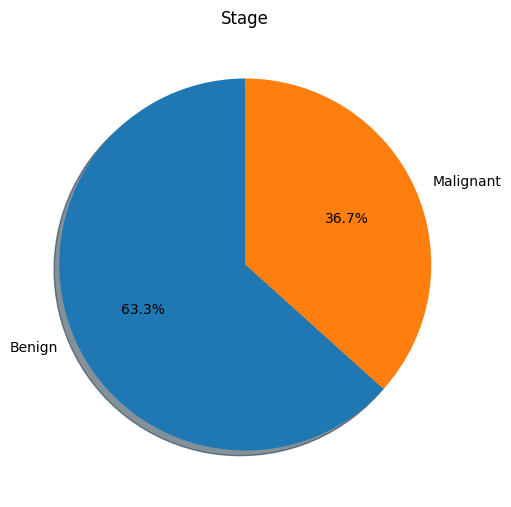

In [ ]:
Tumor_Type_flg = patient_info['Tumor_Type'].value_counts()
display(Tumor_Type_flg)
fig = plt.figure(figsize =(6, 9))
plt.pie( Tumor_Type_flg , labels=Tumor_Type_flg.index , autopct='%1.1f%%', shadow=True, startangle=90 )
plt.title('Stage')
plt.show()

In [ ]:
labels = {0:"Benign",1:"Malignant"}

In [ ]:
def get_data (data_dir ):
    X = list()
    y=list()
    img_size = 256
    for index, row in patient_info.iterrows():
        path = os.path.join(data_dir, str (row['Patient_Num']))
        label = row['Tumor_type_label']
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(e , row['Patient_Num'] )
    return X , y

In [ ]:
X , y  = get_data("/content/gdrive/MyDrive/Thesis_Classification/PatientWiseImage")

In [ ]:
dict(zip(list(y),[list(y).count(i) for i in list(y)]))

{0.0: 2660, 1.0: 1540}

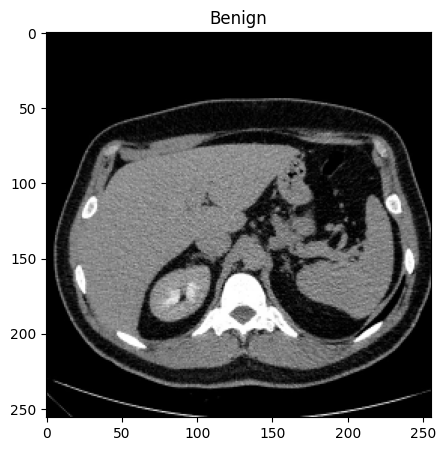

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[10])
plt.title(labels[y[10]])
plt.show()

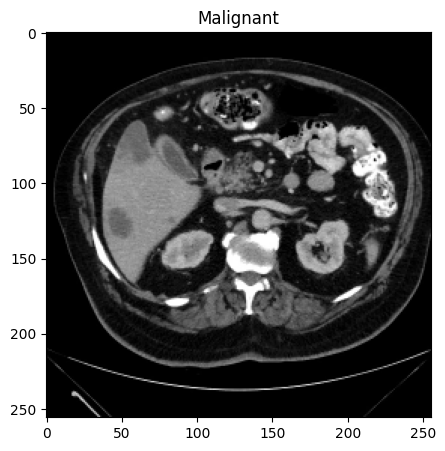

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[-20])
plt.title(labels[y[-20]])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.10)

In [ ]:
print ("Number images for training : {}".format(len (x_train)))
print ("Number images for testing : {}".format(len (x_test)))
print ("Number images for Validation : {}".format(len (x_val)))

Number images for training : 2940
Number images for testing : 1134
Number images for Validation : 126


In [ ]:
dict(zip(list(y_val),[list(y_val).count(i) for i in list(y_val)]))

{0.0: 76, 1.0: 50}

In [ ]:
dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)]))

{0.0: 1872, 1.0: 1068}

In [ ]:
def data_prepare (X , y , folder_name , labels ) :
    path = "/content/gdrive/MyDrive/Thesis_Classification/{}".format(folder_name)
    os.mkdir(path)
    # create folder for labels
    for key , value in labels.items()  :
        path = "/content/gdrive/MyDrive/Thesis_Classification/{}/{}".format(folder_name,value)
        os.mkdir(path)

    if len (X) != len (y) :
      print ("error size data X and y is not equal")
      return

    for index , value in enumerate(y) :
      im = Image.fromarray(X[index])
      path = "/content/gdrive/MyDrive/Thesis_Classification/{}/{}/{}.jpeg".format(folder_name,labels[value],str(index))
      im.save(path)
    return

In [ ]:
data_prepare (X=x_train ,y=y_train ,folder_name="train", labels=labels )

In [ ]:
data_prepare (X=x_test ,y=y_test ,folder_name="test", labels=labels )

In [ ]:
data_prepare (X=x_val ,y=y_val ,folder_name="validation", labels=labels )

# Genrating Images

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis_Classification/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 2940 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis_Classification/test',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1134 images belonging to 2 classes.


In [ ]:
validation_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis_Classification/validation',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 126 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
history=model.fit(training_set,
                         steps_per_epoch = (2940 /32),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (126 /32))

Epoch 1/50
91/91 [==============================] - 414s 4s/step - loss: 0.6377 - accuracy: 0.6452 - val_loss: 0.5924 - val_accuracy: 0.6190
Epoch 2/50
91/91 [==============================] - 52s 571ms/step - loss: 0.5856 - accuracy: 0.7024 - val_loss: 0.4692 - val_accuracy: 0.8016
Epoch 3/50
91/91 [==============================] - 47s 510ms/step - loss: 0.5020 - accuracy: 0.7561 - val_loss: 0.3775 - val_accuracy: 0.8571
Epoch 4/50
91/91 [==============================] - 52s 565ms/step - loss: 0.4558 - accuracy: 0.7946 - val_loss: 0.3329 - val_accuracy: 0.8968
Epoch 5/50
91/91 [==============================] - 48s 524ms/step - loss: 0.4037 - accuracy: 0.8218 - val_loss: 0.3097 - val_accuracy: 0.9127
Epoch 6/50
91/91 [==============================] - 48s 514ms/step - loss: 0.3409 - accuracy: 0.8582 - val_loss: 0.2409 - val_accuracy: 0.9127
Epoch 7/50
91/91 [==============================] - 46s 503ms/step - loss: 0.3004 - accuracy: 0.8738 - val_loss: 0.1880 - val_accuracy: 0.9444
E

In [ ]:
loss,accuracy=model.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

36/36 [==============================] - 380s 11s/step - loss: 0.0961 - accuracy: 0.9683
Test Loss     = 0.09606661647558212
Test Accuracy = 0.9682539701461792


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize = (15 ,15) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')
ax.spines['bottom'].set_color('#000000')

Text(0.5, 1.0, 'Training and Validation Accuracy')

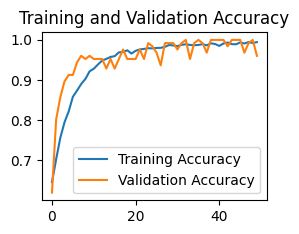

In [ ]:
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

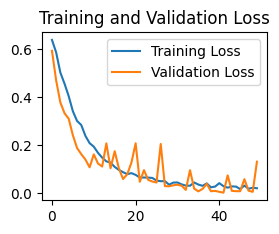

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2']

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Benign'
l_Benign =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Benign=[0]*len(filelist)
print ("Number of images for Benign :" , len (filelist))

Number of images for Benign : 712


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Benign.append(test_image)

In [ ]:
l_Benign_result=[]
for i in range(len(l_Benign)):
    # Assuming x is your Sequential model
    predictions = model.predict(l_Benign[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Benign_result.append(predicted_classes)

1/1 [==============================] - 0s 28ms/step


In [ ]:
l_Benign_draw=[]
for i in range(len(l_Benign_result)):
    if(l_Benign_result[i] ==0):
        l_Benign_draw.append("Benign")
    else:
        l_Benign_draw.append("Malignant")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Benign_draw),[list(l_Benign_draw).count(i) for i in list(l_Benign_draw)])))
display('==='*10)

'=============================='

{'Benign': 712}

'=============================='

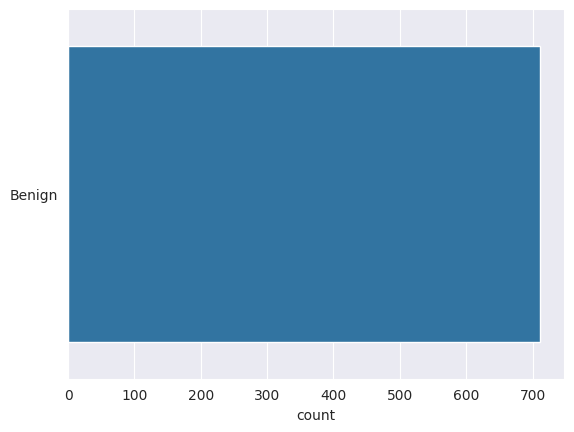

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Benign_draw)
plt.show()

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Malignant'
l_Malignant =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Malignant=[1]*len(filelist)
print ("Number of images for Malignant :" , len (filelist))

Number of images for Malignant : 422


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img), target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Malignant.append(test_image)

In [ ]:
l_Malignant_result=[]
for i in range(len(l_Malignant)):
    # Assuming x is your Sequential model
    predictions = model.predict(l_Malignant[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Malignant_result.append(predicted_classes)

1/1 [==============================] - 0s 19ms/step


In [ ]:
l_Malignant_draw=[]
for i in range(len(l_Malignant_result)):

    if (l_Malignant_result[i][0] ==1):
        l_Malignant_draw.append("Malignant")
    else:
        l_Malignant_draw.append("Benign")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Malignant_draw),[list(l_Malignant_draw).count(i) for i in list(l_Malignant_draw)])))
display('==='*10)

'=============================='

{'Malignant': 407, 'Benign': 15}

'=============================='

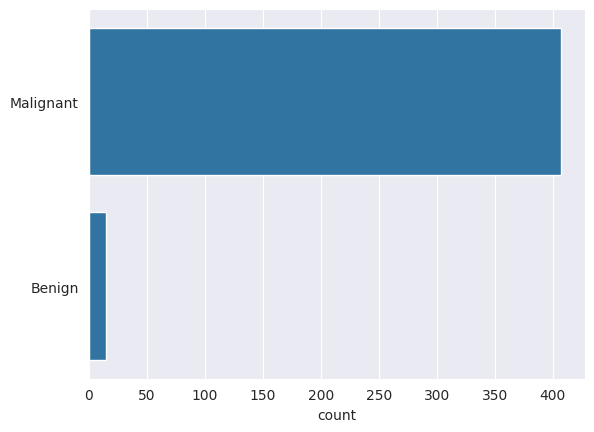

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Malignant_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)

Training Set Clases
{'Benign': 0, 'Malignant': 1}
Testing Set Clases
{'Benign': 0, 'Malignant': 1}


In [ ]:
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_Malignant+y_Benign , l_Malignant_result+l_Benign_result, target_names=target_names))


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99       712
   Malignant       1.00      0.96      0.98       422

    accuracy                           0.99      1134
   macro avg       0.99      0.98      0.99      1134
weighted avg       0.99      0.99      0.99      1134



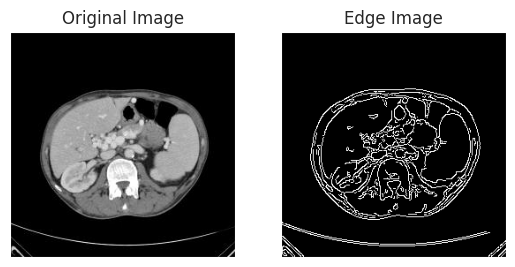

In [ ]:
import cv2
import matplotlib.pyplot as plt

path = '/content/gdrive/MyDrive/Thesis_Classification/validation/Benign/90.jpeg'

img = cv2.imread(path)

if img is None:
    print("Error: Unable to load image.")
else:

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_img, 100, 200)

    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()



In [ ]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

In [ ]:
base_model_2 = Sequential()
base_model_2.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model_2.add(Dropout(0.25))
base_model_2.add(Flatten())
base_model_2.add(Dense(units = 128, activation = 'relu'))
base_model_2.add(Dense(2, activation='softmax'))

94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
base_model_2.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )


In [ ]:
base_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23850242 (90.98 MB)
Trainable params: 23797122 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history=base_model_2.fit(training_set,validation_data=validation_set,epochs=50,callbacks=[stop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 525s 5s/step - loss: 1.2901 - accuracy: 0.6939 - val_loss: 0.8916 - val_accuracy: 0.3968
Epoch 2/50
92/92 [==============================] - 58s 629ms/step - loss: 0.3581 - accuracy: 0.8391 - val_loss: 0.7692 - val_accuracy: 0.3968
Epoch 3/50
92/92 [==============================] - 57s 610ms/step - loss: 0.2320 - accuracy: 0.9112 - val_loss: 0.6800 - val_accuracy: 0.6032
Epoch 4/50
92/92 [==============================] - 57s 612ms/step - loss: 0.1540 - accuracy: 0.9452 - val_loss: 0.6798 - val_accuracy: 0.6032
Epoch 5/50
92/92 [==============================] - 58s 624ms/step - loss: 0.1053 - accuracy: 0.9626 - val_loss: 0.7799 - val_accuracy: 0.4127
Epoch 6/50
92/92 [==============================] - 57s 612ms/step - loss: 0.0933 - accuracy: 0.9687 - val_loss: 1.0282 - val_accuracy: 0.3968
Epoch 7/50
92/92 [==============================] - 56s 611ms/step - loss: 0.0883 - accuracy: 0.9694 - val_loss: 1.4445 - val_accuracy: 0.5159
Epoch 8/50
9

In [ ]:
loss,accuracy=base_model_2.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

36/36 [==============================] - 396s 11s/step - loss: 0.0986 - accuracy: 0.9762
Test Loss     = 0.09862376004457474
Test Accuracy = 0.976190447807312


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

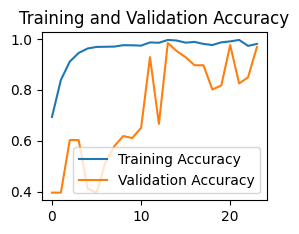

In [ ]:
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

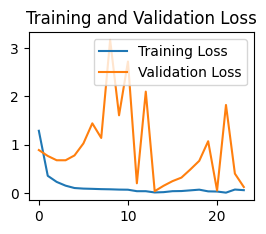

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2']

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Benign'
l_Benign =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Benign=[0]*len(filelist)
print ("Number of images for Benign :" , len (filelist))

Number of images for Benign : 712


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Benign.append(test_image)

In [ ]:
l_Benign_result=[]
for i in range(len(l_Benign)):
    # Assuming x is your Sequential model
    predictions = base_model_2.predict(l_Benign[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Benign_result.append(predicted_classes)

1/1 [==============================] - 0s 22ms/step


In [ ]:
l_Benign_draw=[]
for i in range(len(l_Benign_result)):
    if(l_Benign_result[i] ==0):
        l_Benign_draw.append("Benign")
    else:
        l_Benign_draw.append("Malignant")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Benign_draw),[list(l_Benign_draw).count(i) for i in list(l_Benign_draw)])))
display('==='*10)

'=============================='

{'Malignant': 166, 'Benign': 546}

'=============================='

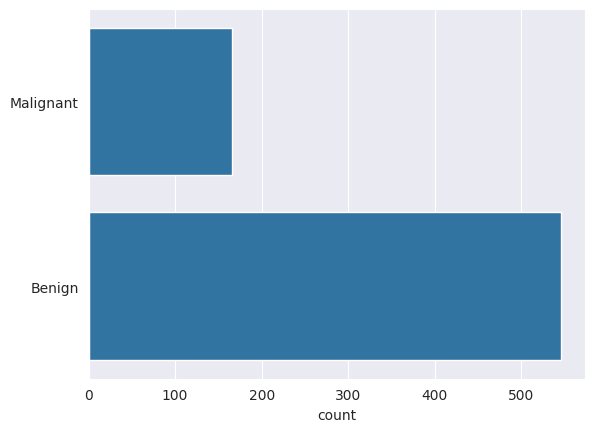

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Benign_draw)
plt.show()

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Malignant'
l_Malignant =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Malignant=[1]*len(filelist)
print ("Number of images for Malignant :" , len (filelist))

Number of images for Malignant : 422


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img), target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Malignant.append(test_image)

In [ ]:
l_Malignant_result=[]
for i in range(len(l_Malignant)):
    # Assuming x is your Sequential model
    predictions = base_model_2.predict(l_Malignant[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Malignant_result.append(predicted_classes)

1/1 [==============================] - 0s 31ms/step


In [ ]:
l_Malignant_draw=[]
for i in range(len(l_Malignant_result)):

    if (l_Malignant_result[i][0] ==1):
        l_Malignant_draw.append("Malignant")
    else:
        l_Malignant_draw.append("Benign")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Malignant_draw),[list(l_Malignant_draw).count(i) for i in list(l_Malignant_draw)])))
display('==='*10)

'=============================='

{'Benign': 313, 'Malignant': 109}

'=============================='

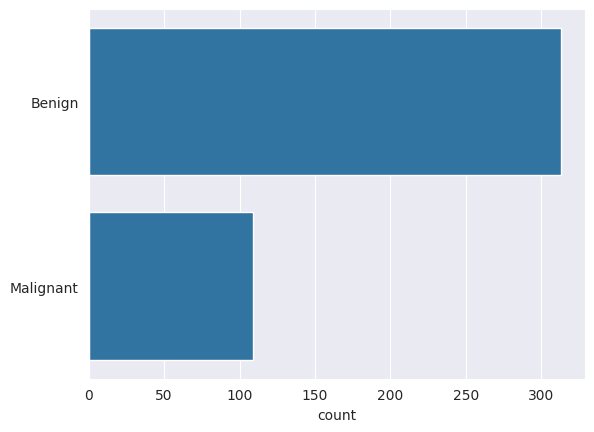

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Malignant_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)

Training Set Clases
{'Benign': 0, 'Malignant': 1}
Testing Set Clases
{'Benign': 0, 'Malignant': 1}


In [ ]:
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_Malignant+y_Benign , l_Malignant_result+l_Benign_result, target_names=target_names))


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Benign       0.64      0.77      0.70       712
   Malignant       0.40      0.26      0.31       422

    accuracy                           0.58      1134
   macro avg       0.52      0.51      0.50      1134
weighted avg       0.55      0.58      0.55      1134



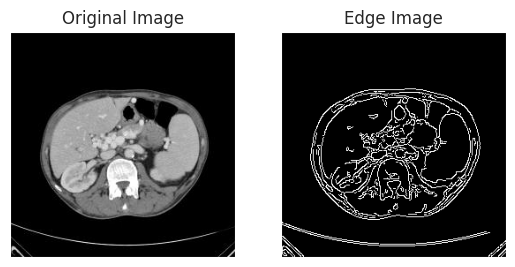

In [ ]:
import cv2
import matplotlib.pyplot as plt

path = '/content/gdrive/MyDrive/Thesis_Classification/validation/Benign/90.jpeg'

img = cv2.imread(path)

if img is None:
    print("Error: Unable to load image.")
else:

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_img, 100, 200)

    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()


In [ ]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [ ]:
from tensorflow.keras.applications import Xception
# Create a Sequential model
base_model_3 = Sequential()

# Add Xception as a layer
xception_layer = Xception(weights='imagenet', include_top=False, pooling='max')
base_model_3.add(xception_layer)

# Add dropout layer
base_model_3.add(Dropout(0.25))

# Flatten the output
base_model_3.add(Flatten())

# Add dense layers
base_model_3.add(Dense(units=128, activation='relu'))
base_model_3.add(Dense(units=2, activation='softmax'))

# Display model summary
#base_model_2.summary()

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model_3.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )

In [ ]:
base_model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 21124010 (80.58 MB)
Trainable params: 21069482 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
history=base_model_3.fit(training_set,validation_data=validation_set,epochs=50,callbacks=[stop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 1112s 12s/step - loss: 0.5625 - accuracy: 0.6833 - val_loss: 1.3520 - val_accuracy: 0.6032
Epoch 2/50
92/92 [==============================] - 62s 668ms/step - loss: 0.3568 - accuracy: 0.8864 - val_loss: 0.5190 - val_accuracy: 0.7857
Epoch 3/50
92/92 [==============================] - 62s 670ms/step - loss: 0.2147 - accuracy: 0.9316 - val_loss: 2.0272 - val_accuracy: 0.6825
Epoch 4/50
92/92 [==============================] - 61s 656ms/step - loss: 0.1394 - accuracy: 0.9531 - val_loss: 2.1282 - val_accuracy: 0.7778
Epoch 5/50
92/92 [==============================] - 62s 667ms/step - loss: 0.0865 - accuracy: 0.9680 - val_loss: 0.1877 - val_accuracy: 0.9603
Epoch 6/50
92/92 [==============================] - 61s 664ms/step - loss: 0.1109 - accuracy: 0.9629 - val_loss: 0.9224 - val_accuracy: 0.8413
Epoch 7/50
92/92 [==============================] - 60s 644ms/step - loss: 0.0662 - accuracy: 0.9796 - val_loss: 1.5285 - val_accuracy: 0.7619
Epoch 8/50

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )

Training Set Clases :  {'Benign': 0, 'Malignant': 1}
Testing Set Clases :  {'Benign': 0, 'Malignant': 1}


In [ ]:
loss,accuracy=base_model_3.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

36/36 [==============================] - 388s 11s/step - loss: 0.2946 - accuracy: 0.9189
Test Loss     = 0.2946356236934662
Test Accuracy = 0.9188712239265442


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

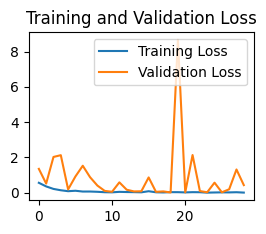

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

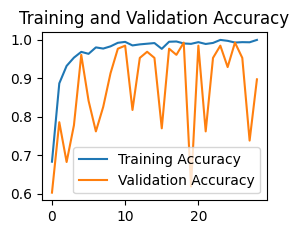

In [ ]:
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2']

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Benign'
l_Benign =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Benign=[0]*len(filelist)
print ("Number of images for Benign :" , len (filelist))

Number of images for Benign : 712


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Benign.append(test_image)

In [ ]:
l_Benign_result=[]
for i in range(len(l_Benign)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Benign[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Benign_result.append(predicted_classes)

1/1 [==============================] - 0s 19ms/step


In [ ]:
l_Benign_draw=[]
for i in range(len(l_Benign_result)):
    if(l_Benign_result[i] ==0):
        l_Benign_draw.append("Benign")
    else:
        l_Benign_draw.append("Malignant")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Benign_draw),[list(l_Benign_draw).count(i) for i in list(l_Benign_draw)])))
display('==='*10)

'=============================='

{'Benign': 712}

'=============================='

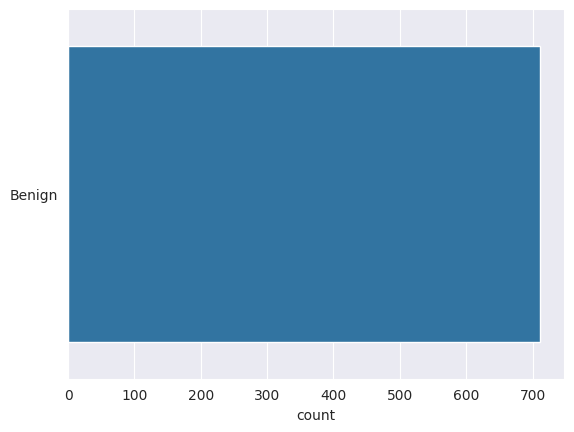

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Benign_draw)
plt.show()

In [ ]:
path='/content/gdrive/MyDrive/Thesis_Classification/test/Malignant'
l_Malignant =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Malignant=[1]*len(filelist)
print ("Number of images for Malignant :" , len (filelist))

Number of images for Malignant : 422


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img), target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Malignant.append(test_image)

In [ ]:
l_Malignant_result=[]
for i in range(len(l_Malignant)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Malignant[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Malignant_result.append(predicted_classes)

1/1 [==============================] - 0s 20ms/step


In [ ]:
l_Malignant_draw=[]
for i in range(len(l_Malignant_result)):

    if (l_Malignant_result[i][0] ==1):
        l_Malignant_draw.append("Malignant")
    else:
        l_Malignant_draw.append("Benign")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Malignant_draw),[list(l_Malignant_draw).count(i) for i in list(l_Malignant_draw)])))
display('==='*10)

'=============================='

{'Benign': 422}

'=============================='

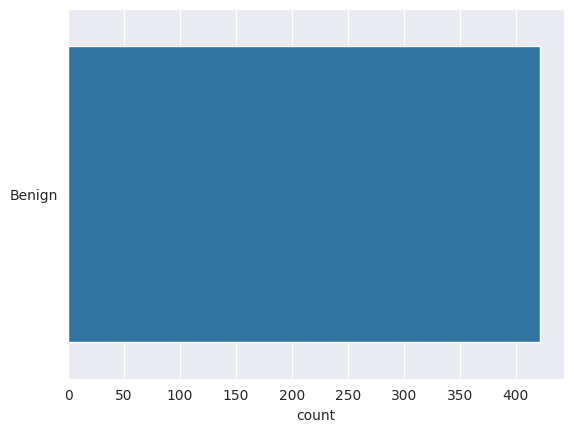

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming l_Benign_draw is your data for visualization
sns.set_style('darkgrid')
sns.countplot(l_Malignant_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)

Training Set Clases
{'Benign': 0, 'Malignant': 1}
Testing Set Clases
{'Benign': 0, 'Malignant': 1}


In [ ]:
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_Malignant+y_Benign , l_Malignant_result+l_Benign_result, target_names=target_names))


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Benign       0.63      1.00      0.77       712
   Malignant       0.00      0.00      0.00       422

    accuracy                           0.63      1134
   macro avg       0.31      0.50      0.39      1134
weighted avg       0.39      0.63      0.48      1134



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


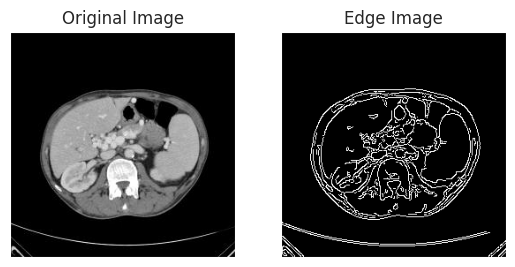

In [ ]:
import cv2
import matplotlib.pyplot as plt

path = '/content/gdrive/MyDrive/Thesis_Classification/validation/Benign/90.jpeg'

img = cv2.imread(path)

if img is None:
    print("Error: Unable to load image.")
else:

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray_img, 100, 200)

    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

    plt.show()